In [1]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
from tqdm import tqdm

from mpmath import fp

#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
torch.cuda.empty_cache()
manualSeed = 999 # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results
#! Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 
#! Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


False
Random Seed:  999


In [2]:
from scipy.special import gamma,zeta,jv,jn_zeros,kv
from scipy.interpolate import griddata,RegularGridInterpolator,CubicSpline

import qcdlib.params as params
import qcdlib.cfg as cfg
from qcdlib.alphaS  import ALPHAS
from qcdlib.alphaS_dev  import ALPHAS as ALPHAS_DEV
from qcdlib.eweak   import EWEAK
from qcdlib.mellin import MELLIN
import qcdlib.special as special

from qcf.qcd_qcf_1d import PDF
from qcf.qcd_ff_1d import FF_PIP

from tools.tools import lprint

In [3]:
mellin = MELLIN(npts=4)
alphaS = ALPHAS()
pdf = PDF(mellin,alphaS)
ff = FF_PIP(mellin,alphaS)

In [4]:
class MODEL:
    
    def __init__(self):
        #--params
        euler=special.euler

        self.Q0 = np.sqrt(cfg.Q20)
        self.C1=2*np.exp(-euler)
        self.C2=1
        
        self.bmax = self.C1/self.Q0 #--so that mub > mu_0
    
    #============================================================
    #--Defining functions associated with bstar
    #============================================================
    #--typical logarithm in perturbative expansions
    def get_Log(self,bT,mu):  
        """
        Typical log in the expansion
        """
        return np.log(mu*bT/self.C1)

    #--Setting up b_*
    def get_bstar(self,bT):
        """
        Returns b*
        """
        return bT/np.sqrt(1+bT**2/self.bmax**2)

    def get_mub(self,bT): 
        """
        Returns mub* 
        """
        return self.C1/self.get_bstar(bT)


In [5]:
tmdmodel = MODEL()

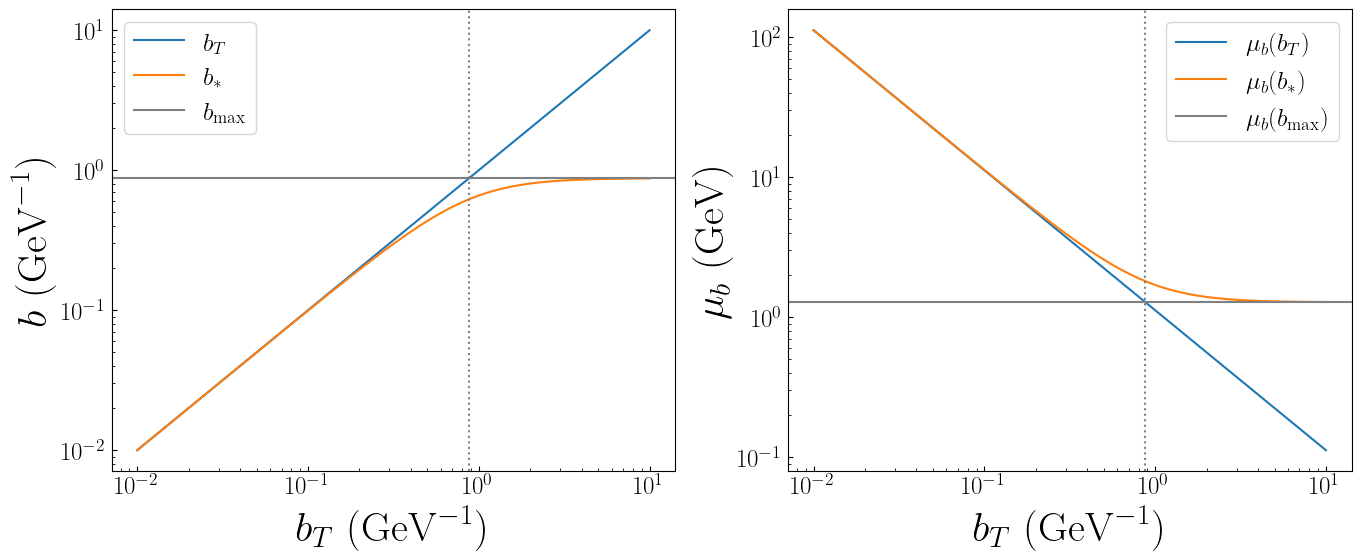

In [6]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

bT = 10**np.linspace(-2,1,100)

bstar = tmdmodel.get_bstar(bT)

mubstar = tmdmodel.get_mub(bT)
mu_nobstar = tmdmodel.C1 / bT

ax=py.subplot(nrows,ncols,1)
ax.plot(bT,bT,label=r'$b_T$')
ax.plot(bT,bstar,label=r'$b_*$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y=tmdmodel.bmax,c='grey',label=r'$b_{\rm max}$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$b~({\rm GeV}^{-1})$',size=30)
ax.loglog()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)

ax=py.subplot(nrows,ncols,2)
ax.plot(bT,mu_nobstar,label=r'$\mu_b(b_T)$')
ax.plot(bT,mubstar,label=r'$\mu_b(b_*)$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y= tmdmodel.C1 / tmdmodel.bmax,ls='-',c='grey',label=r'$\mu_b(b_{\rm max})$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
ax.semilogx()
ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$\mu_b~({\rm GeV})$',size=30)
ax.legend(fontsize=18)


In [7]:
class PDF_OPE:
    
    def __init__(self,pdf):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.pdf = pdf
        self.pdf.storage_flag = True
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        """
        In this version, we ignore bottom quarks
        """
        # quarkcharges = np.zeros(11)
        # quarkcharges[0] = 0 # gluon
        # quarkcharges[1] = 2/3 # u
        # quarkcharges[2] =-1/3 # d
        # quarkcharges[3] =-1/3 # s
        # quarkcharges[4] = 2/3 # c
        # quarkcharges[5] =-1/3 # b

        # quarkcharges[-1] =-2/3 # baru
        # quarkcharges[-2] = 1/3 # bard
        # quarkcharges[-3] = 1/3 # bars
        # quarkcharges[-4] =-2/3 # barc
        # quarkcharges[-5] = 1/3 # barb

        #--flav mapping: {0:u,1:d,2:s,3:c,4:cb,5:sb,6:db,7:ub}
        quarkcharges = np.zeros(9)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        # self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        self.fmap={1:'u',2:'d',3:'s',4:'c',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        
        self.NLOq1= -1/N - 1/(N+1) - 2*special.euler - 2*psi0N # M transform of Pqq=(2/(1-x)_{+} -1-x)
        self.NLOq2=  1/N - 1/(N+1) # M transform of (1-x)

        self.NLOg1= 1/N - 2/(N+1) + 2/(N+2)  # M transform of Pgq=1-2x(1-x)
        self.NLOg2= 1/(N+1)-1/(N+2)  # M tranform of x(1-x) 

        
    def get_OPE_TMDPDF(self,x,bT):
        """
        Returns an 8-dimensional array of flavors for the OPE for a given x and bT
        x: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(x,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.pdf.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.pdf.evolve(mub**2)
            
            moments=self.pdf.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+2*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.TF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((9,N.size),dtype=np.complex128)
            for i in [1,2,3,4]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            xspace_convolutions=np.zeros(9)
            for i in [1,2,3,4]:
                xspace_convolutions[+i]=self.mellin.invert(x,mellin_convolutions[+i])
                xspace_convolutions[-i]=self.mellin.invert(x,mellin_convolutions[-i])
            self.storage_ope[key]=xspace_convolutions

        return self.storage_ope[key]


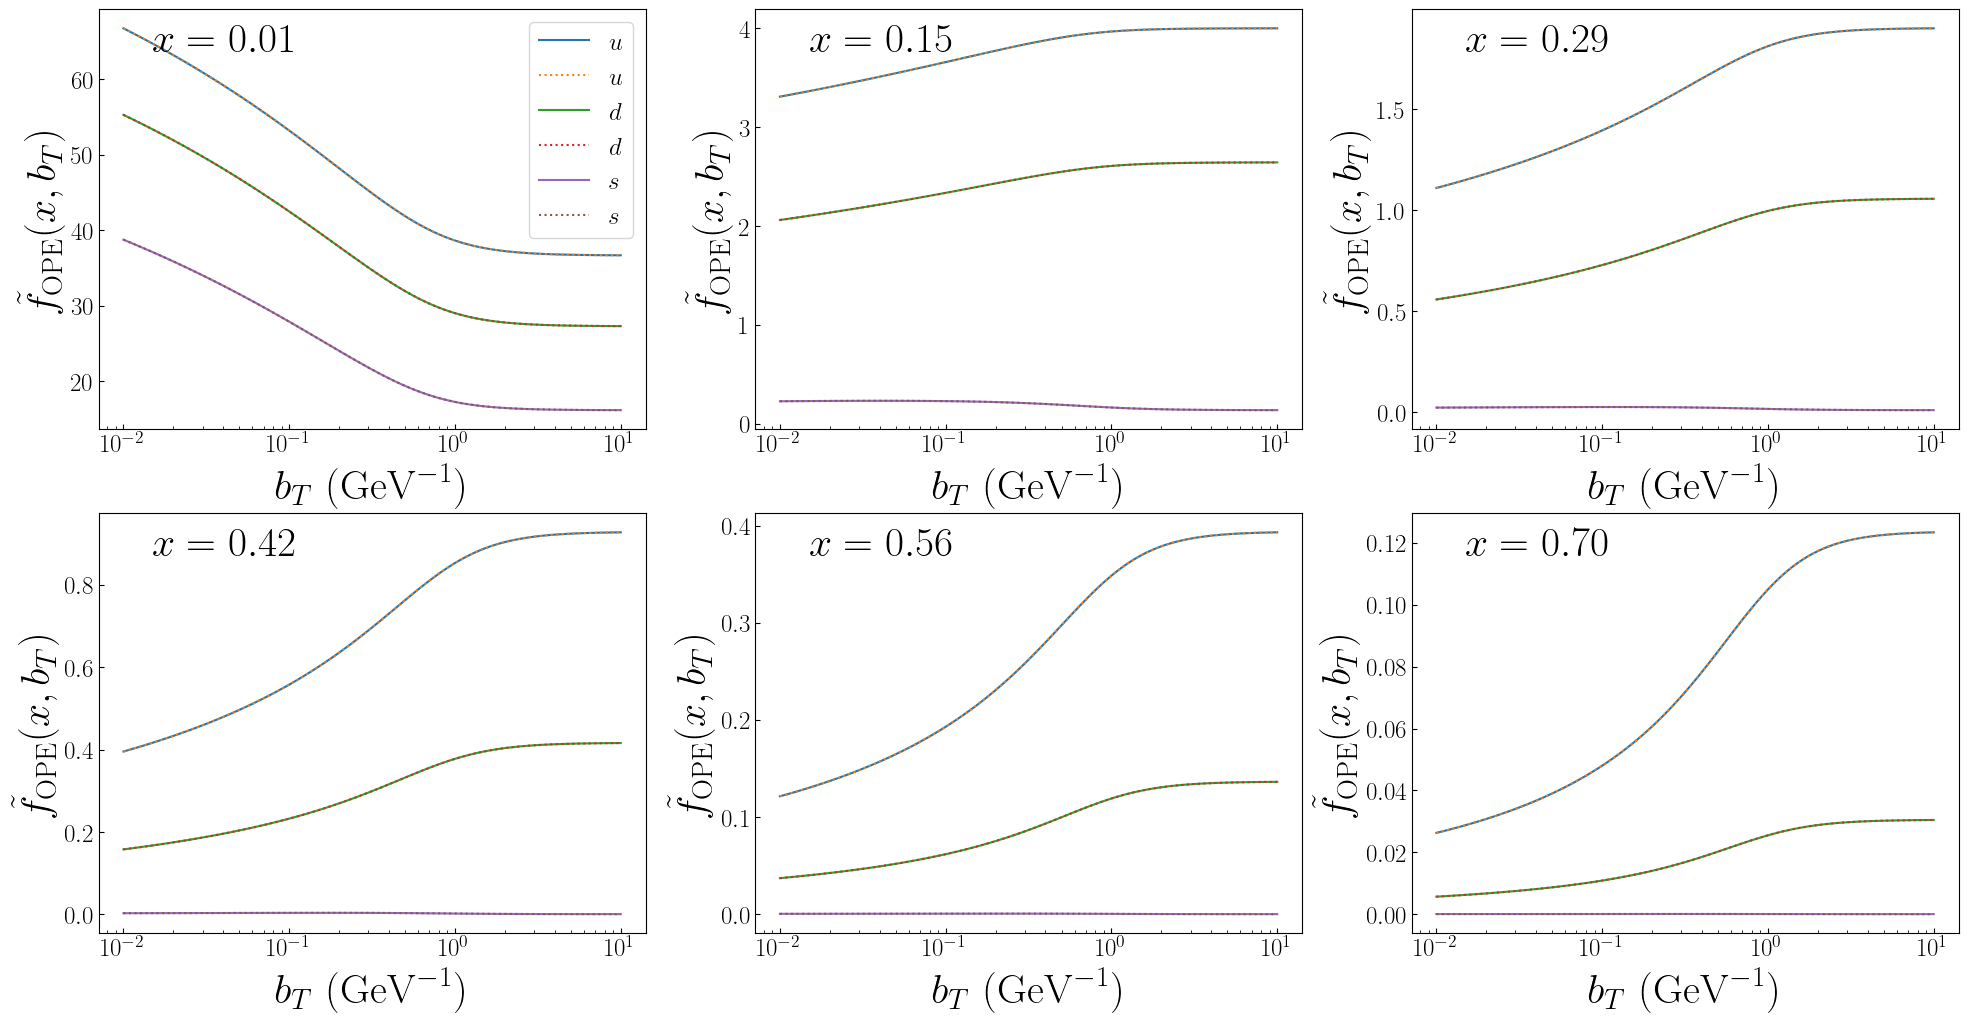

In [8]:
Xs = np.linspace(0.01,0.7,6)
bTs = 10**np.linspace(-2,1,100)

ope = PDF_OPE(pdf)

nrows,ncols=2,3
py.figure(figsize=(8*ncols,6*nrows))
cnt=0

flav_map = ['g','u','d','s','c','cb','sb','db','ub']
flav_lab = [r'$g$',r'$u$',r'$d$',r'$s$',r'$c$',r'$\bar{c}$',r'$\bar{s}$',r'$\bar{d}$',r'$\bar{u}$']
for x in Xs:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)

    opes = np.zeros((9,len(bTs)))
    pdfs = np.zeros((9,len(bTs)))
    for i in range(len(bTs)):
        opetmd = ope.get_OPE_TMDPDF(x,bTs[i])
        mub = tmdmodel.get_mub(bTs[i])
        for j in range(len(opes)):
            opes[j][i] = opetmd[j]
            pdfs[j][i] = pdf.get_xF(x,mub**2,flav_map[j]) / x

    for i in range(len(opes)):
        if i in [0,4,5,6,7,8,9,10]: continue
        ax.plot(bTs, opes[i],label=flav_lab[i])
        ax.plot(bTs,pdfs[i],':',label=flav_lab[i])

    ax.semilogx()
    ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
    ax.set_ylabel(r'$\tilde{f}_{\rm OPE}(x,b_T)$',size=30)
    ax.text(0.1,0.9,r'$x=%.2f$'%x,transform=ax.transAxes,size=30)
    if cnt==1: ax.legend(fontsize=18)
    ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

## Generate OPE table

In [9]:
ope = PDF_OPE(pdf)

In [10]:
bTs = 10**torch.linspace(-3,1,2000)
mubs = tmdmodel.get_mub(bTs)

In [11]:
X = 10**torch.linspace(-3,0,1000)

In [12]:
flavs = ['u','d','s','c','cb','sb','db','ub']

In [13]:
OPE = torch.zeros((len(flavs),len(X),len(bTs)))

In [14]:
OPE.shape

torch.Size([8, 1000, 2000])

In [15]:
ope.get_OPE_TMDPDF(0.1,1)[7+1]

0.7366275196338192

In [16]:
ope.alphaS.get_alphaS(10**2)

0.1804066287580566

In [17]:
ope.pdf.get_xF(0.1,10**2,'u')

0.5687057323543544

In [18]:
# len(mellin.N)

In [19]:
len(ope.pdf.storage)

101

In [69]:
for i in range(len(flavs)):
    flav = flavs[i]
    lprint('progress:%i/8'%i)
    for j in range(OPE.shape[1]):
        x = X[j].item()
        for k in range(OPE.shape[2]):
            mu = mubs[k].item()
            bT = bTs[k].item()
            #OPE[i,j,k] = conf['pdf'].get_xF(x,mu**2,flav)/x
            OPE[i,j,k] = ope.get_OPE_TMDPDF(x,bT)[i+1]
            # OPE[i,j,k] = pdf.get_xF(x,mu**2,flav) / x


progress:7/8

In [70]:
OPE[0][-1,0]

tensor(6.5720e-07)

In [37]:
OPE[0][-1,0]

tensor(6.5720e-07)

In [ ]:
X[-1],bTs[0]

In [71]:
OPE.shape

torch.Size([8, 1000, 2000])

/scratch/slurm/42262872/.cache/tmp/ipykernel_2288539/1386646225.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.plot(X,torch.tensor(X)*OPE[0].T[bTidx],label=r'$u$')
/scratch/slurm/42262872/.cache/tmp/ipykernel_2288539/1386646225.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.plot(X,torch.tensor(X)*OPE[1].T[bTidx],label=r'$d$')


Text(0, 0.5, '$x \\tilde{f}_{\\rm OPE}(x,b_T)$')

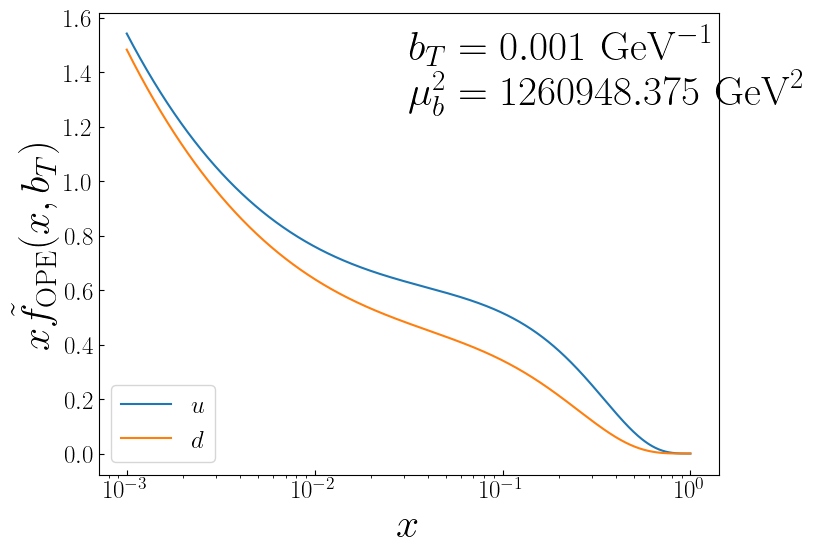

In [72]:
nrows,ncols=1,1
fig=py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

bTidx = 0

ax.plot(X,torch.tensor(X)*OPE[0].T[bTidx],label=r'$u$')
ax.plot(X,torch.tensor(X)*OPE[1].T[bTidx],label=r'$d$')
ax.semilogx()
ax.tick_params(direction='in',labelsize=18)
ax.set_xlabel(r'$x$',size=30)
ax.text(0.5,0.9,r'$b_T=%.3f~{\rm GeV}^{-1}$'%bTs[bTidx],transform=ax.transAxes,size=30)
ax.text(0.5,0.8,r'$\mu_b^2=%.3f~{\rm GeV}^2$'%(mubs[bTidx]**2),transform=ax.transAxes,size=30)
ax.legend(fontsize=18)
ax.set_ylabel(r'$x \tilde{f}_{\rm OPE}(x,b_T)$',size=30)

In [74]:
OPE_orig = torch.load('tables/OPE.pth',weights_only=False)

In [72]:
bTs.shape

torch.Size([2000])

In [73]:
info = {}
info['flavors']=flavs
info['X'] = X
info['bT'] = bTs

In [62]:
torch.save(info,"../tables/OPE_info.pth")

In [ ]:
torch.max(torch.abs(OPE_orig - OPE) / OPE)

In [57]:
# torch.save(OPE,"../tables/OPE.pth")

In [20]:
class PERTURBATIVE_EVOLUTION:
    
    def __init__(self,alphaS,tmdmodel):

        self.iorder = cfg.tmd_resummation_order

        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        self.zeta2 = zeta(2)
        self.zeta3 = zeta(3)
        self.zeta4 = zeta(4)
        self.zeta5 = zeta(5)

        self.alphaS = alphaS
        self.tmdmodel=tmdmodel

        self.storage_Sudakov={}

    def reset_storage_Sudakov(self):
        self.storage_Sudakov={}


    #============================================================
    #--Setting up Gamma_cusp
    #============================================================
    """
    \$\Gamma\$-cusp

     notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

     Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
     - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
     """

    def get_Gamma0(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 4. * self.CF

    def get_Gamma1(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF * (self.CA * (67/9 - np.pi**2/3)\
                   - 20/9 * self.TR * Nf)

    def get_Gamma2(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF *(self.CA**2 * (245/6 - 134/27*np.pi**2 + 11/45*np.pi**4 + 22/3*self.zeta3) \
                    + self.CA * self.TR * Nf * (-418/27 + 40/27*np.pi**2 - 56/3*self.zeta3)\
                    + self.CF * self.TR * Nf * (-55/3 + 16 * self.zeta3) - 16/27 * self.TR**2 * Nf**2 )

    def get_Gamma3(self,mu):
        #--aS**4
        Nf=self.alphaS.get_Nf(mu**2)
        dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
        dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

        return  self.CF*( \
                dFA*(7040/3*self.zeta5 +256/3*self.zeta3-768*(self.zeta3**2) -256*self.zeta2 -15872/35*(self.zeta2**3))\
                +dFF*Nf*(-2560/3*self.zeta5 -512/3*self.zeta3 +512*self.zeta2)\
                +(Nf**3)*(-32/81 +64/27*self.zeta3)\
                +self.CF*(Nf**2)*(2392/81 -640/9*self.zeta3 +64/5*(self.zeta2**2))\
                +(self.CF**2)*Nf*(572/9 -320*self.zeta5 +592/3*self.zeta3)\
                +self.CA*(Nf**2)*(923/81 +2240/27*self.zeta3 -608/81*self.zeta2 -224/15*(self.zeta2**2))\
                +self.CF*self.CA*Nf*(-34066/81 +160*self.zeta5 +3712/9*self.zeta3 +440/3*self.zeta2 -128*self.zeta2*self.zeta3 -352/5*(self.zeta2**2))\
                +(self.CA**2)*Nf*(-24137/81 +2096/9*self.zeta5 -23104/27*self.zeta3 +20320/81*self.zeta2 \
                +448/3*self.zeta2*self.zeta3 -352/15*(self.zeta2**2))\
                +(self.CA**3)*(84278/81 - 3608/9*self.zeta5 +20944/27*self.zeta3 -16*(self.zeta3**2) \
                -88400/81*self.zeta2 -352/3*self.zeta2*self.zeta3 +3608/5*(self.zeta2**2)-20032/105*(self.zeta2**3)))     


    #============================================================
    #--Setting up gamma_J
    #============================================================
    """
    Here we calculate the \$\gamma_{J}\$ Eq. (58) of PhysRevD.96.054011
    """
    def get_gammaJ1(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 6. * self.CF

    def get_gammaJ2(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * (3. - 4. * np.pi**2 + 48. * self.zeta3)\
                        + self.CF * self.CA * (961./27. + 11. * np.pi**2/3. - 52. * self.zeta3)\
                        + self.CF * Nf * (-130./27. - 2. * np.pi**2/3.) 

    def get_gammaJ3(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * Nf * (-2953./27. + 26. * np.pi**2/9 + 28. * np.pi**4/27 - 512. * self.zeta3/9.)\
                        + self.CF * Nf**2 * (-4834./729. + 20. * np.pi**2/27. + 16. * self.zeta3/27. )\
                        + self.CF**3 * (29. + 6. * np.pi**2 + 16. * np.pi**4/5. + 136. * self.zeta3 - 32. * np.pi**2 * self.zeta3/3. - 480. * self.zeta5)\
                        + self.CA**2 * self.CF * (139345./1458. + 7163. * np.pi**2/243. + 83. * np.pi**4/45. - 7052. * self.zeta3/9. + 88. * np.pi**2 * self.zeta3/9. + 272. * self.zeta5 )\
                        + self.CA * self.CF * Nf * (17318./729. - 2594. * np.pi**2/243. - 22. * np.pi**4/45. + 1928. * self.zeta3/27.)\
                        + self.CA * self.CF**2 * (151./2. - 410. * np.pi**2/9. - 494. * np.pi**4/135. + 1688. * self.zeta3/3. + 16. * np.pi**2 * self.zeta3/3. + 240. * self.zeta5)


    #============================================================
    #--Setting up perturbative evolution
    #============================================================
    """
    Perturbative part of the evolution  (perturbative Sudakov and Collins-Soper kernel)

    for gamma3 we use Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D
    """

    def get_Ktilde(self,bT,mu):
        """
        Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        log=self.tmdmodel.get_Log(bT,mu) #- Typical logarithm
        Nf=self.alphaS.get_Nf(mu**2)

        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-np.pi**2/3)*self.CA - (20/9)*self.TR*Nf
        Gamma3 = self.CA**2*(245/6 - 134*np.pi**2/27 + 11*np.pi**4/45 + 22*self.zeta3/3) \
                        + self.CA*self.TR*Nf*(-418/27 + 40*np.pi**2/27 - 56*self.zeta3/3) \
                        + self.CF*self.TR*Nf*(-55/3 + 16*self.zeta3) - (16/27)*self.TR**2*Nf**2
        beta1 = (11/3)*self.CA - (4/3)*self.TR*Nf # 
        beta2 = 34*self.CA**2/3 - 20*self.CA*self.TR*Nf/3 - 4*self.CF*self.TR*Nf # 

        d20 = self.CA*(404/27 - 14*self.zeta3) - 112*self.TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-self.CA**2/2)*(-176*self.zeta3*self.zeta2/3 + 6392*self.zeta2/81 + 12328*self.zeta3/27 + 154*self.zeta4/3 - 192*self.zeta5 - 297029/729) \
                    - self.CA*self.TR*Nf*(-824*self.zeta2/81 - 904*self.zeta3/27 + 20*self.zeta4/3 + 62626/729) \
                    - 2*self.TR**2*Nf**2*(-32*self.zeta3/9 - 1856/729) \
                    - self.CF*self.TR*Nf*(-304*self.zeta3/9 - 16*self.zeta4 + 1711/27)
        ######################################

        Ktilde = 0

        if self.iorder>0: 

            Ktilde += -8 * self.CF * aS * log

        if self.iorder>1:

            Ktilde += 8 * self.CF * aS**2 * (  \
                        +  (2/3 * Nf - 11/3 * self.CA) * log**2 \
                        +  (-67/9 * self.CA + np.pi**2/3 * self.CA + 10/9 * Nf) * log \
                        +  (7/2 * self.zeta3 - 101/27) * self.CA + 14/27 * Nf )

        if self.iorder>2: # Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D

            Ktilde += -2*self.CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869

        return Ktilde


    def get_gammaF(self,mu):
        """
        Anomalous dimension of TMD operator expanded in alphaS, Eq. (58) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gammaF = 0

        if self.iorder>0:
            GAMMA1 = self.get_gammaJ1(mu)
            gammaF += GAMMA1 * aS

        if self.iorder>1:
            GAMMA2 = self.get_gammaJ2(mu)           
            gammaF += aS**2 * GAMMA2

        if self.iorder>2:
            GAMMA3 = self.get_gammaJ3(mu)
            gammaF += aS**3 * GAMMA3

        return gammaF

    def get_gammaK(self,mu):
        """
        Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gamma0 = self.get_Gamma0(mu)        
        gammaK = 2 * gamma0 * aS

        if self.iorder>0: 
            gamma1 = self.get_Gamma1(mu)
            gammaK += aS**2 * 2 * gamma1

        if self.iorder>1:
            gamma2 = self.get_Gamma2(mu)
            gammaK += aS**3 * 2 * gamma2

        if self.iorder>2:
            gamma3 = self.get_Gamma3(mu)
            gammaK += aS**4 * 2 * gamma3

        return gammaK

    def get_integrand_gammas(self,mup,zeta):
        return 1/mup*(self.get_gammaF(mup)-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup))

    def get_eta_Gamma_analytic(self,mu0,muf):
        result = 0
        if self.iorder==0:
            Nf = self.alphaS.get_Nf(mu0**2)
            gamma0 = 2 * self.get_Gamma0(mu0)
            beta0 = self.alphaS.beta[Nf,0]

            alpha_F = self.alphaS.get_alphaS(muf**2)
            alpha_0 = self.alphaS.get_alphaS(mu0**2)
            
            eta_Gamma = -1/2 * (gamma0 / beta0 * np.log(alpha_F/alpha_0))

            result += eta_Gamma

        return result

    def get_Sudakov_analytic_integral(self,mu0,muf,Q2):
        Q = Q2**0.5
        result = 0
        if self.iorder==0:
            Nf = self.alphaS.get_Nf(mu0**2)
            gamma0 = 2 * self.get_Gamma0(mu0)
            beta0 = self.alphaS.beta[Nf,0]

            alpha_F = self.alphaS.get_alphaS(muf**2)
            alpha_0 = self.alphaS.get_alphaS(mu0**2)
            
            eta_Gamma = -1/2 * (gamma0 / beta0 * np.log(alpha_F/alpha_0))
            K_Gamma = gamma0 * np.pi / beta0**2 * (1 / alpha_F + (np.log(alpha_F/alpha_0) - 1) / alpha_0)

            result += -np.log(Q / mu0) * eta_Gamma + K_Gamma

        return result

    def get_Sudakov_perturbative(self,muQ,zeta,bT,method='analytic'):
        """
        perturbative part of the evolution in the solution 
        maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011 
        Returns perturbative Sudakov using b* and mub* 
        """
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        bstar = self.tmdmodel.get_bstar(bT) # returns b*

        key = (muQ,zeta,bstar)
        if method=='numerical':#key not in self.storage_Sudakov:
            integral_gammas=quad(lambda mup: self.get_integrand_gammas(mup,zeta),mub,muQ)[0]            
            self.storage_Sudakov[key]=np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + integral_gammas

        elif method=='analytic':
            self.storage_Sudakov[key] = np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + self.get_Sudakov_analytic_integral(mub,muQ,zeta)
        return self.storage_Sudakov[key] 

    def get_exp_Sudakov_perturbative(self,Q,bT,method='analytic'):
        """
        Exponential of perturbative part of the evolution 
        in the solution maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011


        For the purposes of this code, I am assuming that zeta=Q**2 and that muQ = Q.
        This does not necessarily have to happen!
        """
        muQ = Q
        zeta = Q**2
        return np.exp(self.get_Sudakov_perturbative(muQ,zeta,bT,method)) 

    def get_Sudakov_perturbative_Q0toQ(self,Q0,muQ,zeta,bT,method='analytic'):
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        bstar = self.tmdmodel.get_bstar(bT) # returns b*

        term1 = np.log(np.sqrt(zeta / Q0**2)) * self.get_Ktilde(bstar,mub)
        term2 = self.get_Sudakov_analytic_integral(Q0,muQ,zeta)
        term3 = self.get_eta_Gamma_analytic(Q0,mub) * np.log(np.sqrt(zeta/Q0**2))
        return term1 + term2 + term3
    
    def get_exp_Sudakov_perturbative_Q0toQ(self,Q,Q0,bT,method='analytic'):
        muQ=Q
        zeta=Q**2
        return np.exp(self.get_Sudakov_perturbative_Q0toQ(Q0,muQ,zeta,bT,method))


    def get_Sudakov_perturbative_Q0toQ_bTindependent(self,Q0,muQ,zeta,method='analytic'):
        return self.get_Sudakov_analytic_integral(Q0,muQ,zeta)
        
    def get_exp_Sudakov_perturbative_Q0toQ_bTindependent(self,Q,Q0,method='analytic'):
        muQ=Q
        zeta=Q**2
        return np.exp(self.get_Sudakov_perturbative_Q0toQ_bTindependent(Q0,muQ,zeta,method))

    def get_exponent_of_Q_over_Q0(self,bT,Q0):
        """
        This piece will be in the exponent of (Q/Q0)**(result)
        But the evaluation of the integrals is independent of Q.
        """
        mub = self.tmdmodel.get_mub(bT)
        bstar = self.tmdmodel.get_bstar(bT)

        term1 = self.get_Ktilde(bstar,mub)
        term2 = self.get_eta_Gamma_analytic(Q0,mub)
        return term1 + term2

In [21]:
cfg.alphaS_order

0

In [22]:
pertevo = PERTURBATIVE_EVOLUTION(alphaS,tmdmodel)

In [23]:

bTs = 10**np.linspace(-2,2,100)
Q = np.linspace(3,10,50)

sudN = np.zeros((len(bTs),len(Q)))
sudA = np.zeros((len(bTs),len(Q)))
for i in range(len(bTs)):
    for j in range(len(Q)):
        # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
        sudN[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],method='numerical')
        sudA[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],method='analytic')
#sud=np.array(sud)


In [24]:
for i in range(len(sudN)):
    for j in range(len(sudN[i])):
        if np.abs((sudN[i,j] - sudA[i,j])/sudA[i,j]) > 1e-3: print(bTs[i],Q[j])

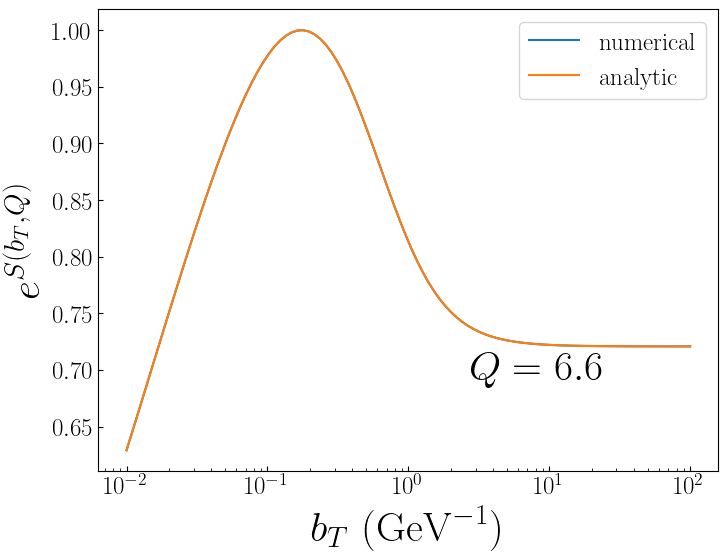

In [25]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

idx = 25
ax.plot(bTs,sudN.T[idx],label=r'$\rm numerical$')
ax.plot(bTs,sudA.T[idx],label=r'$\rm analytic$')
ax.semilogx()
ax.text(0.6,0.2,r'$Q=%.1f$'%Q[idx],transform=ax.transAxes,size=30)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

## Make grid used for interpolation

In [26]:
bTs = 10**torch.linspace(-3,1,2000)

In [27]:
# bs = tmdmodel.get_bstar(bT)

In [28]:
Q = 10**torch.linspace(0,4,1000)

In [29]:
t0=time.time()
# sudN = torch.zeros((len(bTs),len(Q)))
sudA = torch.zeros((len(Q),len(bTs)))
for i in range(len(Q)):
    # lprint('progress:%i/%i'%(i,len(bTs)))
    for j in range(len(bTs)):
        # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
        # sudN[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],method='numerical')
        sudA[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[i].item(),bTs[j].item(),method='analytic')
t1=time.time()
print('time taken for',len(bTs)*len(Q),'computations is',t1-t0,'s')

time taken for 2000000 computations is 68.70483112335205 s


In [ ]:
torch.save(sudA,"tables/evo.pth")

In [30]:
info = {}
info['Q'] = Q
info['bT'] = bTs

In [ ]:
torch.save(info,"tables/evo_info.pth")

In [31]:
cfg.Q20**0.5

1.28

In [32]:
t0=time.time()
# sudN = np.zeros((len(bTs),len(Q)))
sudA = torch.zeros(len(bTs))
for i in range(len(bTs)):
    # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
    # sudN[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],method='numerical')
    sudA[i] = pertevo.get_exp_Sudakov_perturbative(cfg.Q20**0.5,bTs[i].item(),method='analytic')
t1=time.time()
print('time taken for',len(bTs),'computations is',t1-t0,'s')

time taken for 2000 computations is 0.08396315574645996 s


In [27]:
torch.save(sudA,"tables/evo_toQ0.pth")

In [33]:
info = {}
info['bT'] = bTs

In [29]:
torch.save(info,"tables/evo_toQ0_info.pth")

In [34]:
# t0=time.time()
# sudN = torch.zeros((len(bTs),len(Q)))
# sudA = torch.zeros((len(bTs),len(Q)))
# for i in range(len(Q)):
#     for j in range(len(bTs)):
#         # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
#         # sudN[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],method='numerical')
#         #sudA[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],method='analytic')
#         sudA[i][j] = pertevo.get_exp_Sudakov_perturbative_Q0toQ(Q[i].item(),cfg.Q20**0.5,bTs[j].item(),method='analytic')
# t1=time.time()
# print('time taken for',len(bTs)*len(Q),'computations is',t1-t0,'s')

In [35]:
# torch.save(sudA,"tables/evo_Q0toQ.pth")

In [36]:
# info = {}
# info['Q'] = Q
# info['bT'] = bTs

In [37]:
# torch.save(info,"tables/evoQ0toQ_info.pth")

In [38]:
t0=time.time()
sudA = torch.zeros(len(Q))
for i in range(len(Q)):
    sudA[i] = pertevo.get_exp_Sudakov_perturbative_Q0toQ_bTindependent(Q[i].item(),cfg.Q20**0.5,method='analytic')
t1=time.time()
print('time taken for',len(Q),'computations is',t1-t0,'s')

time taken for 1000 computations is 0.01749110221862793 s


In [39]:
torch.save(sudA,"tables/evo_Q0toQ_bTindependent.pth")

In [40]:
info = {}
info['Q'] = Q

In [41]:
torch.save(info,"tables/evo_Q0toQ_bTindependent_info.pth")

In [42]:
t0=time.time()
sudA = torch.zeros(len(bTs))
for i in range(len(bTs)):
    sudA[i] = pertevo.get_exponent_of_Q_over_Q0(bTs[i].item(),cfg.Q20**0.5)
t1=time.time()
print('time taken for',len(bTs),'computations is',t1-t0,'s')

time taken for 2000 computations is 0.048924922943115234 s


In [43]:
torch.save(sudA,"tables/evo_Q0toQ_bTdependent.pth")

In [44]:
info = {}
info['bT'] = bTs

In [45]:
torch.save(info,"tables/evo_Q0toQ_bTdependent_info.pth")

In [46]:
grid1 = torch.load('tables/evo.pth',weights_only=False)
grid2 = torch.load('tables/evo_toQ0.pth',weights_only=False)
grid3 = torch.load('tables/evo_Q0toQ_bTindependent.pth',weights_only=False)
grid4 = torch.load('tables/evo_Q0toQ_bTdependent.pth',weights_only=False)

In [47]:
base_needed = torch.einsum('Q,b->Qb',(Q/cfg.Q20**0.5),torch.ones(len(bTs)))
grid4_needed = torch.einsum('Q,b->Qb',torch.ones(len(Q)),grid4)

In [48]:
grid4_evo = base_needed**grid4_needed

In [49]:
grid5 = torch.einsum('b,Q,Qb->Qb',grid2,grid3,grid4_evo)

In [50]:
grid5

tensor([[0.0724, 0.0726, 0.0727,  ..., 0.9902, 0.9902, 0.9902],
        [0.0731, 0.0732, 0.0734,  ..., 0.9909, 0.9909, 0.9909],
        [0.0737, 0.0739, 0.0741,  ..., 0.9916, 0.9916, 0.9916],
        ...,
        [0.8549, 0.8543, 0.8537,  ..., 0.0026, 0.0026, 0.0026],
        [0.8538, 0.8532, 0.8526,  ..., 0.0026, 0.0026, 0.0026],
        [0.8527, 0.8521, 0.8515,  ..., 0.0025, 0.0025, 0.0025]])

In [51]:
check = torch.abs(grid1-grid5)/grid1

In [52]:
torch.max(check)

tensor(1.8901e-05)

In [53]:
OPE = torch.load('tables/OPE.pth',weights_only=False)

In [56]:
OPE_info = torch.load('tables/OPE_info.pth',weights_only=False)

In [57]:
evo_toQ0 = torch.load('tables/evo_toQ0.pth',weights_only=False)

In [58]:
evo_toQ0_info = torch.load('tables/evo_toQ0_info.pth',weights_only=False)

In [59]:
OPE_info['bT'] - evo_toQ0_info['bT']

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [60]:
OPE.shape

torch.Size([8, 1000, 2000])

In [61]:
evo_toQ0.shape

torch.Size([2000])

In [65]:
OPEQ0 = torch.einsum('fxb,b->fxb',OPE,evo_toQ0)

In [66]:
OPEQ0.shape

torch.Size([8, 1000, 2000])

In [67]:
torch.save(OPEQ0,'tables/OPE_Q0.pth')

In [74]:
info = {}
info['flavors']=flavs
info['X'] = X
info['bT'] = bTs
info['Q0'] = cfg.Q20**0.5

In [75]:
torch.save(info,'tables/OPE_Q0_info.pth')